Assumes you have run `Train_Testset.ipynb` first to make the `alldata`, `realdist`, and `balanced` train/test splits for the chosen language pair.

# Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [5]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np 
import io
import requests
import csv

In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
#device = torch.device("cuda:0:3" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.

Using device: cpu



In [323]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

## Load datasets

In [324]:
train_alldata = pd.read_csv('../Datasets/train_final_production_alldata.csv')
test_alldata = pd.read_csv('../Datasets/test_final_production_alldata.csv')

In [325]:
train_realdist = pd.read_csv('../Datasets/train_final_production_realdist.csv')
test_realdist = pd.read_csv('../Datasets/test_final_production_realdist.csv')

In [326]:
train_balanced = pd.read_csv('../Datasets/train_final_production_balanced.csv')
test_balanced = pd.read_csv('../Datasets/test_final_production_balanced.csv')

## Get Panphon phonetic features

In [327]:
#get phonetic features using panPhon
ft = panphon.FeatureTable()

In [328]:
train_alldata['features_loan'] = train_alldata.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_alldata['features_orig'] = train_alldata.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_alldata['features_loan'] = test_alldata.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_alldata['features_orig'] = test_alldata.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_alldata['features_loan'] = train_alldata['features_loan'].apply(lambda x:sum(x, []))
train_alldata['features_orig'] = train_alldata['features_orig'].apply(lambda x:sum(x, []))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x:sum(x, []))
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x:sum(x, []))


Pad the phonetic features of the loan word and original word out to the maxlen of the features appearing in the training set (format: `<loan><pad 0s><orig><pad 0s>`).

In [514]:
train_alldata_maxlen = (np.max(train_alldata['features_loan'].str.len()),\
                               np.max(train_alldata['features_orig'].str.len()))

train_alldata['features_loan'] = train_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_alldata['features_orig'] = train_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

train_alldata['features_loan'][np.random.randint(len(train_alldata['features_loan']))],\
train_alldata['features_orig'][np.random.randint(len(train_alldata['features_loan']))]

(array([-1, -1,  1, -1,  1, -1, -1,  0, -1, -1, -1, -1,  1,  1, -1, -1, -1,
        -1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1,
        -1,  0, -1,  0, -1, -1, -1, -1, -1, -1,  1, -1,  0,  0, -1,  1,  1,
         1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
         0, -1,  0,  0, -1,  1,  1,  1,  0, -1, -1,  0,  1, -1, -1,  1,  1,
        -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1,
        -1,  0,  1, -1, -1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [515]:
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_alldata['features_loan'][np.random.randint(len(test_alldata['features_loan']))],\
test_alldata['features_orig'][np.random.randint(len(test_alldata['features_orig']))]

(array([-1, -1,  1, -1, -1, -1, -1,  0, -1, -1, -1,  1, -1,  0,  1, -1, -1,
        -1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1,
        -1,  0, -1,  0, -1, -1, -1,  1, -1, -1, -1, -1,  0,  0, -1,  1,  1,
         1,  0, -1, -1,  0,  1, -1, -1,  1,  1, -1, -1,  0,  0,  0, -1, -1,
         0, -1,  0,  0, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1,
         0,  1, -1, -1, -1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1,
        -1,  0,  1, -1, -1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  1,  1,  0,
         0, -1,  1,  1, -1, -1, -1,  1,  0,  1, -1, -1,  1,  1, -1, -1, -1,
        -1, -1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1,
        -1, -1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

## Add target labels and make train and test sets

In [331]:
Y_train = np.array([y for y in train_alldata['label_bin']])
Y_test = np.array([y for y in test_alldata['label_bin']])
Y_train.shape,Y_test.shape

((11857,), (1320,))

In [332]:
X_train = np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])
X_test = np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                    np.array([x for x in test_alldata['features_orig']])])
X_train.shape,X_test.shape

((11857, 1056), (1320, 1056))

Make a validation split for training the DNN model

In [374]:
#create train and validation splits keeping the composition of labels balanced between them using a random state '1 '

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, stratify=Y_train)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape


(torch.Size([7588, 1056]),
 torch.Size([1897, 1056]),
 torch.Size([7588, 1]),
 torch.Size([1897, 1]))

In [336]:
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

X_test = torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))

X_val = torch.tensor(X_val).to(device)
Y_val = torch.tensor(Y_val).to(device).reshape((-1,1))


In [337]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape
 

(torch.Size([9485, 1056]),
 torch.Size([9485, 1]),
 torch.Size([1320, 1056]),
 torch.Size([1320, 1]),
 torch.Size([2372, 1056]),
 torch.Size([2372, 1]))

In [340]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## DNN Definition

In [341]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            
        )
        self.dropout = nn.Dropout(0.10) 

    def forward(self, x):
        #x = self.flatten(x)
        #logits = self.linear_relu_stack(x)
        logits_new = self.linear_relu_stack(x)
        logits  = self.dropout(logits_new)
        
        return torch.sigmoid(logits), logits_new
        #return logits

In [342]:
model = NeuralNetwork(X_train.shape[1]).to(device)
#model = NeuralNetwork(X_test.shape[1]).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1056, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)


In [346]:
criterion = nn.BCELoss().to(device)

In [347]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [348]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5) 
    return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())

In [349]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [350]:
CUDA_LAUNCH_BLOCKING=1

Train!

In [351]:
# train for 5000 epochs and get the logits 
val_losses = []
train_losses = []
val_accur = []
train_accur = []
logits = []
for epoch in range(5000):

    y_pred = model(X_train.float())[0]
    logits = model(X_train.float())[1]
    #getting logits for test set 
#     y_pred = model(X_test.float())[0]
#     logits = model(X_test.float())[1]
    #y_pred = model(X_train) 
    #print(y_pred)

    #y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, Y_train.float())
    
    #test_loss = criterion(y_pred, Y_test.float())
    #train_loss = criterion(y_pred, Y_train)

    if epoch % 100 == 0:
        train_acc,_ = calculate_accuracy(Y_train, y_pred)

        y_val_pred = model(X_val.float())[0]
        #y_test_pred = torch.squeeze(y_test_pred)
         

        val_loss = criterion(y_val_pred, Y_val.float())

        val_acc, total_corr = calculate_accuracy(Y_val, y_val_pred)
        #print(total_corr)
        
        print(f'''epoch {epoch} Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)} Val set - loss: {round_tensor(val_loss)}, Val accuracy: {round_tensor(val_acc)}
''')
        #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
        #print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())
        
        val_accur.append(val_acc.detach().numpy())
        train_accur.append(train_acc.detach().numpy())

    optimizer.zero_grad()

    train_loss.backward()
    #test_loss.backward()

    optimizer.step()

epoch 0 Train set - loss: 0.681, accuracy: 0.745 Val  set - loss: 0.681, Val accuracy: 0.738

epoch 100 Train set - loss: 0.464, accuracy: 0.819 Val  set - loss: 0.465, Val accuracy: 0.817

epoch 200 Train set - loss: 0.355, accuracy: 0.818 Val  set - loss: 0.356, Val accuracy: 0.819

epoch 300 Train set - loss: 0.345, accuracy: 0.822 Val  set - loss: 0.352, Val accuracy: 0.814

epoch 400 Train set - loss: 0.344, accuracy: 0.817 Val  set - loss: 0.341, Val accuracy: 0.823

epoch 500 Train set - loss: 0.337, accuracy: 0.82 Val  set - loss: 0.334, Val accuracy: 0.827

epoch 600 Train set - loss: 0.336, accuracy: 0.815 Val  set - loss: 0.338, Val accuracy: 0.815

epoch 700 Train set - loss: 0.327, accuracy: 0.818 Val  set - loss: 0.336, Val accuracy: 0.81

epoch 800 Train set - loss: 0.323, accuracy: 0.816 Val  set - loss: 0.327, Val accuracy: 0.816

epoch 900 Train set - loss: 0.312, accuracy: 0.822 Val  set - loss: 0.32, Val accuracy: 0.815

epoch 1000 Train set - loss: 0.303, accuracy:

Plot!

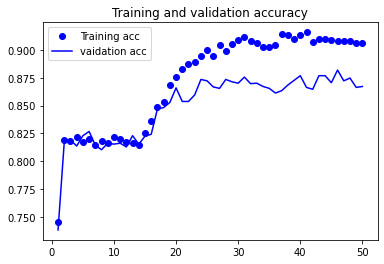

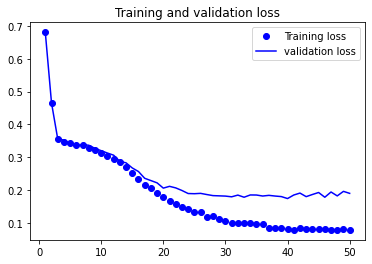

In [352]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accur) + 1)

plt.plot(epochs, train_accur, 'bo', label='Training acc')
plt.plot(epochs, val_accur, 'b', label='vaidation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Setup evaluation datasets

Get Panphon features and pad (use `train_alldata` as already defined above)

In [353]:
train_realdist['features_loan'] = train_realdist.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_realdist['features_orig'] = train_realdist.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_realdist['features_loan'] = test_realdist.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_realdist['features_orig'] = test_realdist.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_realdist['features_loan'] = train_realdist['features_loan'].apply(lambda x:sum(x, []))
train_realdist['features_orig'] = train_realdist['features_orig'].apply(lambda x:sum(x, []))
test_realdist['features_orig'] = test_realdist['features_orig'].apply(lambda x:sum(x, []))
test_realdist['features_loan'] = test_realdist['features_loan'].apply(lambda x:sum(x, []))

train_balanced['features_loan'] = train_balanced.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_balanced['features_orig'] = train_balanced.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_balanced['features_loan'] = test_balanced.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_balanced['features_orig'] = test_balanced.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_balanced['features_loan'] = train_balanced['features_loan'].apply(lambda x:sum(x, []))
train_balanced['features_orig'] = train_balanced['features_orig'].apply(lambda x:sum(x, []))
test_balanced['features_orig'] = test_balanced['features_orig'].apply(lambda x:sum(x, []))
test_balanced['features_loan'] = test_balanced['features_loan'].apply(lambda x:sum(x, []))


In [516]:
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_alldata = torch.tensor(np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])).to(device)
X_test_alldata = torch.tensor(np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                    np.array([x for x in test_alldata['features_orig']])])).to(device)

In [517]:
train_realdist['features_loan'] = train_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_realdist['features_orig'] = train_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_realdist['features_loan'] = test_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_realdist['features_orig'] = test_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_realdist = torch.tensor(np.hstack([np.array([x for x in train_realdist['features_loan']]),\
                     np.array([x for x in train_realdist['features_orig']])])).to(device)
X_test_realdist = torch.tensor(np.hstack([np.array([x for x in test_realdist['features_loan']]),\
                    np.array([x for x in test_realdist['features_orig']])])).to(device)

train_balanced['features_loan'] = train_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_balanced['features_orig'] = train_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_balanced['features_loan'] = test_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_balanced['features_orig'] = test_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_balanced = torch.tensor(np.hstack([np.array([x for x in train_balanced['features_loan']]),\
                     np.array([x for x in train_balanced['features_orig']])])).to(device)
X_test_balanced = torch.tensor(np.hstack([np.array([x for x in test_balanced['features_loan']]),\
                    np.array([x for x in test_balanced['features_orig']])])).to(device)

Get logits from DNN for all datasets/splits

In [364]:
model.eval()

with torch.no_grad():
    train_logits_dnn_alldata = model(X_train_alldata.float())[1].detach().cpu().numpy()
    test_logits_dnn_alldata = model(X_test_alldata.float())[1].detach().cpu().numpy()
    train_logits_dnn_realdist = model(X_train_realdist.float())[1].detach().cpu().numpy()
    test_logits_dnn_realdist = model(X_test_realdist.float())[1].detach().cpu().numpy()
    train_logits_dnn_balanced = model(X_train_balanced.float())[1].detach().cpu().numpy()
    test_logits_dnn_balanced = model(X_test_balanced.float())[1].detach().cpu().numpy()

In [367]:
train_logits_dnn_alldata, test_logits_dnn_alldata,\
train_logits_dnn_realdist, test_logits_dnn_realdist,\
train_logits_dnn_balanced, test_logits_dnn_balanced

(array([[ -8.168253 ],
        [  5.6654778],
        [ -1.99144  ],
        ...,
        [-25.142923 ],
        [ -9.857235 ],
        [-11.477509 ]], dtype=float32),
 array([[ -6.632645 ],
        [-12.517828 ],
        [ -4.8939857],
        ...,
        [  4.328829 ],
        [ -5.4864573],
        [  6.445583 ]], dtype=float32),
 array([[-12.112804 ],
        [  3.9351969],
        [  4.503063 ],
        ...,
        [-20.006413 ],
        [ -8.729936 ],
        [-16.542418 ]], dtype=float32),
 array([[-1.58126945e+01],
        [-1.23463612e+01],
        [ 2.20779514e+00],
        [-2.12806282e+01],
        [-2.41199265e+01],
        [-9.40355301e-01],
        [ 3.53277159e+00],
        [-5.31555843e+00],
        [-2.13989716e+01],
        [-1.03952007e+01],
        [-6.83899879e+00],
        [-2.36320710e+00],
        [-1.96180267e+01],
        [-1.43530643e+00],
        [-1.01868916e+01],
        [-1.52589712e+01],
        [-9.01798248e+00],
        [-7.16112375e+00],
        [ 

Add DNN logit column to production datasets

In [369]:
train_alldata_dnnlogits = pd.read_csv('../Datasets/train_final_production_alldata.csv')
test_alldata_dnnlogits = pd.read_csv('../Datasets/test_final_production_alldata.csv')
train_realdist_dnnlogits = pd.read_csv('../Datasets/train_final_production_realdist.csv')
test_realdist_dnnlogits = pd.read_csv('../Datasets/test_final_production_realdist.csv')
train_balanced_dnnlogits = pd.read_csv('../Datasets/train_final_production_balanced.csv')
test_balanced_dnnlogits = pd.read_csv('../Datasets/test_final_production_balanced.csv')

In [371]:
train_alldata_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_alldata
test_alldata_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_alldata

train_realdist_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_realdist
test_realdist_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_realdist

train_balanced_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_balanced
test_balanced_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_balanced

train_alldata_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_alldata.csv')
test_alldata_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_alldata.csv')

train_realdist_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_realdist.csv')
test_realdist_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_realdist.csv')

train_balanced_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_balanced.csv')
test_balanced_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_balanced.csv')


## Setup data for CNN training

Current CNN approach doesn't really work.  Because the inputs are PanPhon features with padding dependent on the maxlen of the input data, and then reshaped into a square to fit into a 2D CNN, the filter is not able to capture the necessary dependency: that is, the relationship between an L1 feature and an L2 feature at the same approximate position in their respective words (cf., Persian /ɣ/ usually becomes Hindi /q/).  If we reshape the data this way for the network, because the ordering of PanPhon features are effectively conventionlized into a fixed order, a /q/ in an (e.g.) Hindi word is not guaranteed to fall in the same window as the equivalent /ɣ/ in the (e.g.) Persian source word, thus losing the dependency.  Therefore the CNN usually falls into a local minimum of predicting everything to be a non-loan word.  Loss remains relatively compared to the DNN and accuracy plateaus at about 90%.

Use `train_alldata` again

In [497]:
X_train = np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])
Y_train = np.array([y for y in train_alldata['label_bin']])

In [498]:
# create train and validation splits for proper model training while keeping the composition of labels balanced between them using a random state '1 '

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, stratify=Y_train)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((9485, 1056), (2372, 1056), (9485,), (2372,))

In [499]:
# convert them to torch tensors for padding
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

X_test = torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))

X_val = torch.tensor(X_val).to(device)
Y_val = torch.tensor(Y_val).to(device).reshape((-1,1))


/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/2394371174.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).to(device)
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/2394371174.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))


In [500]:
closest_perfect_square = X_train.shape[1]
while (True):
    if np.sqrt(closest_perfect_square) - np.floor(np.sqrt(closest_perfect_square)) != 0:
        closest_perfect_square += 1
    else:
        break
view_shape = int(np.sqrt(closest_perfect_square))
closest_perfect_square,view_shape

(1089, 33)

In [501]:
X_train = F.pad(X_train, pad=(0, closest_perfect_square-X_train.shape[1]), value=0)
X_val = F.pad(X_val, pad=(0, closest_perfect_square-X_val.shape[1]), value=0)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([9485, 1089]),
 torch.Size([2372, 1089]),
 torch.Size([9485, 1]),
 torch.Size([2372, 1]))

## CNN Definition

In [620]:
class CCN_Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 128, 8) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(128, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 32, 2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        #x = torch.randn(33,33).view(-1,1,33,33) #33 because its the square root of 1089
        #x = torch.randn(30,30).view(-1,1,30,30) #30 because its the square root of 900 for real dist train set
        #x = torch.randn(29,29).view(-1,1,29,29) #29 because its the square root of 841 for balanced train set
        x = torch.randn(view_shape,view_shape).view(-1,1,view_shape,view_shape) # for trained model logit prediction, for all data, 1089 is sq of 33
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).
        self.dropout = nn.Dropout(0.1)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(torch.tanh(self.conv1(x)), (2, 2))
        #x = F.max_pool2d(torch.tanh(self.conv2(x)), (1, 1))
        #x = F.max_pool2d(torch.tanh(self.conv3(x)), (1, 1))
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = self.dropout(x)
        x = torch.tanh(self.fc1(x))
        #x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


CNN_Net = CCN_Net() 
CNN_Net = nn.DataParallel(CNN_Net)
CNN_Net.to(device)
print(CNN_Net)

DataParallel(
  (module): CCN_Net(
    (conv1): Conv2d(1, 128, kernel_size=(8, 8), stride=(1, 1))
    (conv2): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
    (conv3): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (fc1): Linear(in_features=21632, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [621]:
X_train = torch.tensor(X_train).view(-1,view_shape,view_shape).to(device)
X_val = torch.tensor(X_val).view(-1,view_shape,view_shape).to(device)
Y_train = torch.tensor(Y_train).to(device)
Y_val = torch.tensor(Y_val).to(device)
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape


/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/2849481093.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).view(-1,view_shape,view_shape).to(device)
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/2849481093.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).view(-1,view_shape,view_shape).to(device)
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/2849481093.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.ten

(torch.Size([9485, 33, 33]),
 torch.Size([2372, 33, 33]),
 torch.Size([9485, 1]),
 torch.Size([2372, 1]))

In [622]:
#optimizer = optim.Adam(CNN_Net.parameters(), lr=0.01)
optimizer = optim.SGD(CNN_Net.parameters(),lr=0.001, momentum=0.0,  weight_decay=0.0, nesterov=False)
#optimizer = torch.optim.RMSprop(CNN_Net.parameters(), lr=0.00001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#loss_function = nn.MSELoss()
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_function = nn.BCELoss().to(device)

In [623]:
from tqdm import tqdm

In [624]:
torch.cuda.empty_cache()

In [625]:
X_val = X_val.unsqueeze(1) #just do it once 

In [626]:
# sets the seed manually to 42
torch.manual_seed(42)
# a = X_val_CNN[torch.randint(len(X_val_CNN), (120,))]  
# # b = Y_val_CNN[torch.randint(len(X_val_CNN), (120,))]  
# # a.shape
# b

# 

In [627]:
torch.initial_seed()

42

In [628]:
#train for 10000 epochs and get the logits 
val_losses = []
train_losses = []
val_accur = []
train_accur = []
train_losses_batch = []
logits = []
BATCH_SIZE = 512
n_epochs = 50
for epoch in range(n_epochs):
    for i in tqdm(range(0, len(X_train), BATCH_SIZE)):
        batch_X = X_train[i:i+BATCH_SIZE].view(-1, 1, view_shape,view_shape)  
        #batch_X = X_train_CNN.view(-1, 1, 29,29)  
        batch_y = Y_train[i:i+BATCH_SIZE]
        
        

        #X_train_CNN = X_train_CNN.view(-1, 1, 33,33) # for balanced train set
        CNN_Net.zero_grad()
        
        y_pred = CNN_Net(batch_X .float())[0]
        #print(y_pred)
        logits = CNN_Net(batch_X.float())[1]
        #getting logits for test set 
    #     y_pred = model(X_test.float())[0]
    #     logits = model(X_test.float())[1]
        #y_pred = model(X_train) 
        #print(y_pred)

        #y_pred = torch.squeeze(y_pred)
        train_loss = loss_function(y_pred, batch_y.float())

        #test_loss = criterion(y_pred, Y_test.float())
        #train_loss = criterion(y_pred, Y_train)
        train_losses.append(train_loss)
        if epoch % (n_epochs // 20) == 0:
            with torch.no_grad():
                CNN_Net.eval()

                val_batch_X = X_val[torch.randint(len(X_val), (BATCH_SIZE,))] 
                val_batch_Y = Y_val[torch.randint(len(X_val), (BATCH_SIZE,))] 

                train_acc,_ = calculate_accuracy(batch_y, y_pred)
                #X_val_CNN= X_val_CNN.unsqueeze(1) don't do it here, it will keep adding a channel dimension every time the for loop operates
                y_val_pred = CNN_Net(val_batch_X.float())[0]
                #print(y_val_pred)
                #y_test_pred = torch.squeeze(y_test_pred)


                val_loss = loss_function(y_val_pred, val_batch_Y.float())

                val_acc, total_corr = calculate_accuracy(val_batch_Y, y_val_pred)
                #print(total_corr)

                print(f'''epoch {epoch} Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)} Val  set - loss: {round_tensor(val_loss)}, Val accuracy: {round_tensor(val_acc)}
        ''')
                #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
                #print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
                train_losses_batch.append(train_loss.detach().numpy())
                val_losses.append(val_loss.detach().numpy())

                train_accur.append(train_acc.detach().numpy())
                val_accur.append(val_acc.detach().numpy())

        optimizer.zero_grad()

        train_loss.backward()
        #test_loss.backward()

        optimizer.step()
    scheduler1.step()

  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:10,  1.80it/s]

epoch 0 Train set - loss: 0.66, accuracy: 0.881 Val  set - loss: 0.663, Val accuracy: 0.863
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:07,  2.35it/s]

epoch 0 Train set - loss: 0.611, accuracy: 0.887 Val  set - loss: 0.605, Val accuracy: 0.912
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:06,  2.50it/s]

epoch 0 Train set - loss: 0.564, accuracy: 0.906 Val  set - loss: 0.56, Val accuracy: 0.92
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:05,  2.58it/s]

epoch 0 Train set - loss: 0.537, accuracy: 0.881 Val  set - loss: 0.536, Val accuracy: 0.891
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:05,  2.72it/s]

epoch 0 Train set - loss: 0.488, accuracy: 0.924 Val  set - loss: 0.513, Val accuracy: 0.887
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  2.86it/s]

epoch 0 Train set - loss: 0.48, accuracy: 0.891 Val  set - loss: 0.482, Val accuracy: 0.893
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:04,  2.87it/s]

epoch 0 Train set - loss: 0.443, accuracy: 0.912 Val  set - loss: 0.464, Val accuracy: 0.895
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.85it/s]

epoch 0 Train set - loss: 0.444, accuracy: 0.889 Val  set - loss: 0.428, Val accuracy: 0.918
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  2.93it/s]

epoch 0 Train set - loss: 0.429, accuracy: 0.891 Val  set - loss: 0.409, Val accuracy: 0.92
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.98it/s]

epoch 0 Train set - loss: 0.409, accuracy: 0.9 Val  set - loss: 0.44, Val accuracy: 0.873
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.00it/s]

epoch 0 Train set - loss: 0.409, accuracy: 0.891 Val  set - loss: 0.392, Val accuracy: 0.912
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:04<00:02,  3.03it/s]

epoch 0 Train set - loss: 0.384, accuracy: 0.906 Val  set - loss: 0.409, Val accuracy: 0.895
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.06it/s]

epoch 0 Train set - loss: 0.402, accuracy: 0.879 Val  set - loss: 0.405, Val accuracy: 0.885
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.09it/s]

epoch 0 Train set - loss: 0.361, accuracy: 0.908 Val  set - loss: 0.348, Val accuracy: 0.928
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  3.11it/s]

epoch 0 Train set - loss: 0.366, accuracy: 0.902 Val  set - loss: 0.385, Val accuracy: 0.893
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.12it/s]

epoch 0 Train set - loss: 0.38, accuracy: 0.883 Val  set - loss: 0.342, Val accuracy: 0.92
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.15it/s]

epoch 0 Train set - loss: 0.357, accuracy: 0.898 Val  set - loss: 0.364, Val accuracy: 0.904
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  3.09it/s]

epoch 0 Train set - loss: 0.358, accuracy: 0.893 Val  set - loss: 0.366, Val accuracy: 0.9
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.95it/s]


epoch 0 Train set - loss: 0.353, accuracy: 0.9 Val  set - loss: 0.361, Val accuracy: 0.898
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.95it/s]

epoch 2 Train set - loss: 0.282, accuracy: 0.924 Val  set - loss: 0.34, Val accuracy: 0.896
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.03it/s]

epoch 2 Train set - loss: 0.344, accuracy: 0.887 Val  set - loss: 0.333, Val accuracy: 0.898
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.10it/s]

epoch 2 Train set - loss: 0.309, accuracy: 0.906 Val  set - loss: 0.32, Val accuracy: 0.908
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.11it/s]

epoch 2 Train set - loss: 0.354, accuracy: 0.881 Val  set - loss: 0.382, Val accuracy: 0.873
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  2.98it/s]

epoch 2 Train set - loss: 0.273, accuracy: 0.924 Val  set - loss: 0.308, Val accuracy: 0.912
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  2.98it/s]

epoch 2 Train set - loss: 0.334, accuracy: 0.891 Val  set - loss: 0.371, Val accuracy: 0.879
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.02it/s]

epoch 2 Train set - loss: 0.294, accuracy: 0.912 Val  set - loss: 0.338, Val accuracy: 0.896
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.98it/s]

epoch 2 Train set - loss: 0.338, accuracy: 0.889 Val  set - loss: 0.303, Val accuracy: 0.916
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  2.97it/s]

epoch 2 Train set - loss: 0.334, accuracy: 0.891 Val  set - loss: 0.321, Val accuracy: 0.906
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.05it/s]

epoch 2 Train set - loss: 0.317, accuracy: 0.9 Val  set - loss: 0.311, Val accuracy: 0.91
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.07it/s]

epoch 2 Train set - loss: 0.336, accuracy: 0.891 Val  set - loss: 0.332, Val accuracy: 0.896
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  2.99it/s]

epoch 2 Train set - loss: 0.307, accuracy: 0.906 Val  set - loss: 0.377, Val accuracy: 0.877
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.04it/s]

epoch 2 Train set - loss: 0.353, accuracy: 0.879 Val  set - loss: 0.344, Val accuracy: 0.895
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.99it/s]

epoch 2 Train set - loss: 0.295, accuracy: 0.908 Val  set - loss: 0.343, Val accuracy: 0.891
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.03it/s]

epoch 2 Train set - loss: 0.315, accuracy: 0.902 Val  set - loss: 0.298, Val accuracy: 0.914
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.98it/s]

epoch 2 Train set - loss: 0.342, accuracy: 0.883 Val  set - loss: 0.377, Val accuracy: 0.873
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.03it/s]

epoch 2 Train set - loss: 0.316, accuracy: 0.898 Val  set - loss: 0.352, Val accuracy: 0.889
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.03it/s]

epoch 2 Train set - loss: 0.321, accuracy: 0.893 Val  set - loss: 0.302, Val accuracy: 0.916
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.06it/s]


epoch 2 Train set - loss: 0.319, accuracy: 0.9 Val  set - loss: 0.333, Val accuracy: 0.896
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.97it/s]

epoch 4 Train set - loss: 0.269, accuracy: 0.924 Val  set - loss: 0.39, Val accuracy: 0.873
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.99it/s]

epoch 4 Train set - loss: 0.34, accuracy: 0.887 Val  set - loss: 0.291, Val accuracy: 0.92
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.09it/s]

epoch 4 Train set - loss: 0.301, accuracy: 0.906 Val  set - loss: 0.328, Val accuracy: 0.898
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.12it/s]

epoch 4 Train set - loss: 0.352, accuracy: 0.881 Val  set - loss: 0.328, Val accuracy: 0.904
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.13it/s]

epoch 4 Train set - loss: 0.262, accuracy: 0.924 Val  set - loss: 0.38, Val accuracy: 0.873
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.12it/s]

epoch 4 Train set - loss: 0.33, accuracy: 0.891 Val  set - loss: 0.35, Val accuracy: 0.893
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.08it/s]

epoch 4 Train set - loss: 0.287, accuracy: 0.912 Val  set - loss: 0.33, Val accuracy: 0.9
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.01it/s]

epoch 4 Train set - loss: 0.335, accuracy: 0.889 Val  set - loss: 0.293, Val accuracy: 0.916
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.02it/s]

epoch 4 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.327, Val accuracy: 0.902
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.05it/s]

epoch 4 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.352, Val accuracy: 0.889
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.05it/s]

epoch 4 Train set - loss: 0.334, accuracy: 0.891 Val  set - loss: 0.329, Val accuracy: 0.902
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.07it/s]

epoch 4 Train set - loss: 0.303, accuracy: 0.906 Val  set - loss: 0.323, Val accuracy: 0.902
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.08it/s]

epoch 4 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.351, Val accuracy: 0.891
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.06it/s]

epoch 4 Train set - loss: 0.289, accuracy: 0.908 Val  set - loss: 0.278, Val accuracy: 0.922
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.04it/s]

epoch 4 Train set - loss: 0.312, accuracy: 0.902 Val  set - loss: 0.368, Val accuracy: 0.881
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.08it/s]

epoch 4 Train set - loss: 0.341, accuracy: 0.883 Val  set - loss: 0.347, Val accuracy: 0.891
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.12it/s]

epoch 4 Train set - loss: 0.313, accuracy: 0.898 Val  set - loss: 0.362, Val accuracy: 0.885
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.12it/s]

epoch 4 Train set - loss: 0.318, accuracy: 0.893 Val  set - loss: 0.307, Val accuracy: 0.908
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.12it/s]


epoch 4 Train set - loss: 0.316, accuracy: 0.9 Val  set - loss: 0.287, Val accuracy: 0.92
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.03it/s]

epoch 6 Train set - loss: 0.267, accuracy: 0.924 Val  set - loss: 0.362, Val accuracy: 0.885
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.91it/s]

epoch 6 Train set - loss: 0.339, accuracy: 0.887 Val  set - loss: 0.343, Val accuracy: 0.895
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  2.97it/s]

epoch 6 Train set - loss: 0.299, accuracy: 0.906 Val  set - loss: 0.278, Val accuracy: 0.92
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:05,  2.99it/s]

epoch 6 Train set - loss: 0.352, accuracy: 0.881 Val  set - loss: 0.292, Val accuracy: 0.916
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.02it/s]

epoch 6 Train set - loss: 0.259, accuracy: 0.924 Val  set - loss: 0.325, Val accuracy: 0.902
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  3.01it/s]

epoch 6 Train set - loss: 0.33, accuracy: 0.891 Val  set - loss: 0.317, Val accuracy: 0.904
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.03it/s]

epoch 6 Train set - loss: 0.285, accuracy: 0.912 Val  set - loss: 0.353, Val accuracy: 0.889
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.02it/s]

epoch 6 Train set - loss: 0.334, accuracy: 0.889 Val  set - loss: 0.307, Val accuracy: 0.91
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  2.98it/s]

epoch 6 Train set - loss: 0.33, accuracy: 0.891 Val  set - loss: 0.296, Val accuracy: 0.914
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.99it/s]

epoch 6 Train set - loss: 0.312, accuracy: 0.9 Val  set - loss: 0.315, Val accuracy: 0.908
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.03it/s]

epoch 6 Train set - loss: 0.333, accuracy: 0.891 Val  set - loss: 0.341, Val accuracy: 0.893
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.01it/s]

epoch 6 Train set - loss: 0.301, accuracy: 0.906 Val  set - loss: 0.347, Val accuracy: 0.893
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.99it/s]

epoch 6 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.322, Val accuracy: 0.902
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.96it/s]

epoch 6 Train set - loss: 0.288, accuracy: 0.908 Val  set - loss: 0.333, Val accuracy: 0.898
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  2.97it/s]

epoch 6 Train set - loss: 0.312, accuracy: 0.902 Val  set - loss: 0.349, Val accuracy: 0.893
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.01it/s]

epoch 6 Train set - loss: 0.34, accuracy: 0.883 Val  set - loss: 0.313, Val accuracy: 0.904
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.96it/s]

epoch 6 Train set - loss: 0.312, accuracy: 0.898 Val  set - loss: 0.296, Val accuracy: 0.914
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  3.02it/s]

epoch 6 Train set - loss: 0.317, accuracy: 0.893 Val  set - loss: 0.349, Val accuracy: 0.893
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.05it/s]


epoch 6 Train set - loss: 0.315, accuracy: 0.9 Val  set - loss: 0.321, Val accuracy: 0.902
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.01it/s]

epoch 8 Train set - loss: 0.266, accuracy: 0.924 Val  set - loss: 0.25, Val accuracy: 0.936
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.04it/s]

epoch 8 Train set - loss: 0.339, accuracy: 0.887 Val  set - loss: 0.361, Val accuracy: 0.885
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.01it/s]

epoch 8 Train set - loss: 0.299, accuracy: 0.906 Val  set - loss: 0.303, Val accuracy: 0.91
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.07it/s]

epoch 8 Train set - loss: 0.352, accuracy: 0.881 Val  set - loss: 0.354, Val accuracy: 0.889
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.14it/s]

epoch 8 Train set - loss: 0.257, accuracy: 0.924 Val  set - loss: 0.342, Val accuracy: 0.893
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.11it/s]

epoch 8 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.346, Val accuracy: 0.893
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.08it/s]

epoch 8 Train set - loss: 0.284, accuracy: 0.912 Val  set - loss: 0.314, Val accuracy: 0.908
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.96it/s]

epoch 8 Train set - loss: 0.334, accuracy: 0.889 Val  set - loss: 0.379, Val accuracy: 0.879
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.01it/s]

epoch 8 Train set - loss: 0.33, accuracy: 0.891 Val  set - loss: 0.349, Val accuracy: 0.893
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.99it/s]

epoch 8 Train set - loss: 0.312, accuracy: 0.9 Val  set - loss: 0.345, Val accuracy: 0.895
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  2.98it/s]

epoch 8 Train set - loss: 0.333, accuracy: 0.891 Val  set - loss: 0.284, Val accuracy: 0.918
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  2.98it/s]

epoch 8 Train set - loss: 0.301, accuracy: 0.906 Val  set - loss: 0.364, Val accuracy: 0.883
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.05it/s]

epoch 8 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.374, Val accuracy: 0.879
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.08it/s]

epoch 8 Train set - loss: 0.287, accuracy: 0.908 Val  set - loss: 0.333, Val accuracy: 0.898
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.01it/s]

epoch 8 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.326, Val accuracy: 0.9
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  3.00it/s]

epoch 8 Train set - loss: 0.34, accuracy: 0.883 Val  set - loss: 0.324, Val accuracy: 0.902
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.03it/s]

epoch 8 Train set - loss: 0.312, accuracy: 0.898 Val  set - loss: 0.312, Val accuracy: 0.906
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.07it/s]

epoch 8 Train set - loss: 0.316, accuracy: 0.893 Val  set - loss: 0.33, Val accuracy: 0.9
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.09it/s]


epoch 8 Train set - loss: 0.315, accuracy: 0.9 Val  set - loss: 0.362, Val accuracy: 0.885
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.06it/s]

epoch 10 Train set - loss: 0.265, accuracy: 0.924 Val  set - loss: 0.302, Val accuracy: 0.91
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.11it/s]

epoch 10 Train set - loss: 0.339, accuracy: 0.887 Val  set - loss: 0.36, Val accuracy: 0.887
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.12it/s]

epoch 10 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.311, Val accuracy: 0.908
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.08it/s]

epoch 10 Train set - loss: 0.352, accuracy: 0.881 Val  set - loss: 0.332, Val accuracy: 0.9
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.08it/s]

epoch 10 Train set - loss: 0.257, accuracy: 0.924 Val  set - loss: 0.302, Val accuracy: 0.912
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.09it/s]

epoch 10 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.326, Val accuracy: 0.9
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.11it/s]

epoch 10 Train set - loss: 0.284, accuracy: 0.912 Val  set - loss: 0.307, Val accuracy: 0.91
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.06it/s]

epoch 10 Train set - loss: 0.334, accuracy: 0.889 Val  set - loss: 0.316, Val accuracy: 0.906
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  2.97it/s]

epoch 10 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.339, Val accuracy: 0.895
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.96it/s]

epoch 10 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.315, Val accuracy: 0.906
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  2.99it/s]

epoch 10 Train set - loss: 0.333, accuracy: 0.891 Val  set - loss: 0.286, Val accuracy: 0.916
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  2.93it/s]

epoch 10 Train set - loss: 0.301, accuracy: 0.906 Val  set - loss: 0.291, Val accuracy: 0.918
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.83it/s]

epoch 10 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.316, Val accuracy: 0.904
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.83it/s]

epoch 10 Train set - loss: 0.286, accuracy: 0.908 Val  set - loss: 0.358, Val accuracy: 0.887
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  2.87it/s]

epoch 10 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.348, Val accuracy: 0.896
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.88it/s]

epoch 10 Train set - loss: 0.34, accuracy: 0.883 Val  set - loss: 0.344, Val accuracy: 0.895
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.94it/s]

epoch 10 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.318, Val accuracy: 0.902
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  2.98it/s]

epoch 10 Train set - loss: 0.316, accuracy: 0.893 Val  set - loss: 0.339, Val accuracy: 0.896
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.03it/s]


epoch 10 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.321, Val accuracy: 0.904
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.21it/s]

epoch 12 Train set - loss: 0.265, accuracy: 0.924 Val  set - loss: 0.352, Val accuracy: 0.889
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.13it/s]

epoch 12 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.325, Val accuracy: 0.902
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.07it/s]

epoch 12 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.365, Val accuracy: 0.885
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.07it/s]

epoch 12 Train set - loss: 0.352, accuracy: 0.881 Val  set - loss: 0.344, Val accuracy: 0.895
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.07it/s]

epoch 12 Train set - loss: 0.256, accuracy: 0.924 Val  set - loss: 0.347, Val accuracy: 0.891
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.06it/s]

epoch 12 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.416, Val accuracy: 0.865
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.02it/s]

epoch 12 Train set - loss: 0.284, accuracy: 0.912 Val  set - loss: 0.371, Val accuracy: 0.881
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.05it/s]

epoch 12 Train set - loss: 0.334, accuracy: 0.889 Val  set - loss: 0.303, Val accuracy: 0.91
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.02it/s]

epoch 12 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.337, Val accuracy: 0.896
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.02it/s]

epoch 12 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.321, Val accuracy: 0.902
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.03it/s]

epoch 12 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.334, Val accuracy: 0.898
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.00it/s]

epoch 12 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.345, Val accuracy: 0.895
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.03it/s]

epoch 12 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.332, Val accuracy: 0.902
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.06it/s]

epoch 12 Train set - loss: 0.286, accuracy: 0.908 Val  set - loss: 0.292, Val accuracy: 0.916
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.08it/s]

epoch 12 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.378, Val accuracy: 0.881
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.11it/s]

epoch 12 Train set - loss: 0.34, accuracy: 0.883 Val  set - loss: 0.415, Val accuracy: 0.861
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.12it/s]

epoch 12 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.325, Val accuracy: 0.9
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.12it/s]

epoch 12 Train set - loss: 0.316, accuracy: 0.893 Val  set - loss: 0.358, Val accuracy: 0.887
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.12it/s]


epoch 12 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.307, Val accuracy: 0.908
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.12it/s]

epoch 14 Train set - loss: 0.265, accuracy: 0.924 Val  set - loss: 0.31, Val accuracy: 0.91
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.17it/s]

epoch 14 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.359, Val accuracy: 0.891
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.17it/s]

epoch 14 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.339, Val accuracy: 0.898
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.15it/s]

epoch 14 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.38, Val accuracy: 0.881
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.09it/s]

epoch 14 Train set - loss: 0.256, accuracy: 0.924 Val  set - loss: 0.384, Val accuracy: 0.877
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.10it/s]

epoch 14 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.342, Val accuracy: 0.895
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.06it/s]

epoch 14 Train set - loss: 0.284, accuracy: 0.912 Val  set - loss: 0.312, Val accuracy: 0.908
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.89it/s]

epoch 14 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.294, Val accuracy: 0.914
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  2.81it/s]

epoch 14 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.376, Val accuracy: 0.879
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.61it/s]

epoch 14 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.34, Val accuracy: 0.9
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:03,  2.59it/s]

epoch 14 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.294, Val accuracy: 0.914
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:04<00:02,  2.59it/s]

epoch 14 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.365, Val accuracy: 0.883
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.57it/s]

epoch 14 Train set - loss: 0.352, accuracy: 0.879 Val  set - loss: 0.356, Val accuracy: 0.889
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:05<00:01,  2.58it/s]

epoch 14 Train set - loss: 0.286, accuracy: 0.908 Val  set - loss: 0.338, Val accuracy: 0.896
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  2.57it/s]

epoch 14 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.309, Val accuracy: 0.912
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.67it/s]

epoch 14 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.4, Val accuracy: 0.867
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:06<00:00,  2.68it/s]

epoch 14 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.336, Val accuracy: 0.896
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  2.69it/s]

epoch 14 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.358, Val accuracy: 0.885
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.81it/s]


epoch 14 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.362, Val accuracy: 0.885
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.90it/s]

epoch 16 Train set - loss: 0.265, accuracy: 0.924 Val  set - loss: 0.356, Val accuracy: 0.889
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.99it/s]

epoch 16 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.347, Val accuracy: 0.893
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  3.00it/s]

epoch 16 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.295, Val accuracy: 0.914
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.03it/s]

epoch 16 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.353, Val accuracy: 0.889
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.01it/s]

epoch 16 Train set - loss: 0.256, accuracy: 0.924 Val  set - loss: 0.341, Val accuracy: 0.896
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  2.98it/s]

epoch 16 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.349, Val accuracy: 0.895
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.01it/s]

epoch 16 Train set - loss: 0.284, accuracy: 0.912 Val  set - loss: 0.342, Val accuracy: 0.895
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.04it/s]

epoch 16 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.327, Val accuracy: 0.898
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.01it/s]

epoch 16 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.306, Val accuracy: 0.912
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.98it/s]

epoch 16 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.329, Val accuracy: 0.898
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.01it/s]

epoch 16 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.311, Val accuracy: 0.91
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.05it/s]

epoch 16 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.345, Val accuracy: 0.891
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.95it/s]

epoch 16 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.339, Val accuracy: 0.898
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.96it/s]

epoch 16 Train set - loss: 0.286, accuracy: 0.908 Val  set - loss: 0.369, Val accuracy: 0.885
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  3.00it/s]

epoch 16 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.302, Val accuracy: 0.914
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.95it/s]

epoch 16 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.382, Val accuracy: 0.877
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.94it/s]

epoch 16 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.373, Val accuracy: 0.881
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  2.98it/s]

epoch 16 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.37, Val accuracy: 0.885
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.02it/s]


epoch 16 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.32, Val accuracy: 0.904
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.81it/s]

epoch 18 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.334, Val accuracy: 0.898
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.95it/s]

epoch 18 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.347, Val accuracy: 0.893
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  3.01it/s]

epoch 18 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.346, Val accuracy: 0.891
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.06it/s]

epoch 18 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.34, Val accuracy: 0.898
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.12it/s]

epoch 18 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.244, Val accuracy: 0.939
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.12it/s]

epoch 18 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.359, Val accuracy: 0.889
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.12it/s]

epoch 18 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.318, Val accuracy: 0.906
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.07it/s]

epoch 18 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.35, Val accuracy: 0.891
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.04it/s]

epoch 18 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.384, Val accuracy: 0.877
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.04it/s]

epoch 18 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.355, Val accuracy: 0.889
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.09it/s]

epoch 18 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.367, Val accuracy: 0.885
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.06it/s]

epoch 18 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.344, Val accuracy: 0.893
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.10it/s]

epoch 18 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.285, Val accuracy: 0.92
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.07it/s]

epoch 18 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.329, Val accuracy: 0.9
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.03it/s]

epoch 18 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.353, Val accuracy: 0.887
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.02it/s]

epoch 18 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.342, Val accuracy: 0.895
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.02it/s]

epoch 18 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.286, Val accuracy: 0.922
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.08it/s]

epoch 18 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.379, Val accuracy: 0.879
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.11it/s]


epoch 18 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.323, Val accuracy: 0.902
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.07it/s]

epoch 20 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.34, Val accuracy: 0.895
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.03it/s]

epoch 20 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.307, Val accuracy: 0.91
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  2.98it/s]

epoch 20 Train set - loss: 0.298, accuracy: 0.906 Val  set - loss: 0.336, Val accuracy: 0.9
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.03it/s]

epoch 20 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.315, Val accuracy: 0.906
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.10it/s]

epoch 20 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.31, Val accuracy: 0.91
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.09it/s]

epoch 20 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.365, Val accuracy: 0.881
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.09it/s]

epoch 20 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.361, Val accuracy: 0.887
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.13it/s]

epoch 20 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.317, Val accuracy: 0.904
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.13it/s]

epoch 20 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.367, Val accuracy: 0.883
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.12it/s]

epoch 20 Train set - loss: 0.311, accuracy: 0.9 Val  set - loss: 0.335, Val accuracy: 0.898
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.16it/s]

epoch 20 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.3, Val accuracy: 0.91
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.17it/s]

epoch 20 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.263, Val accuracy: 0.93
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.15it/s]

epoch 20 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.337, Val accuracy: 0.9
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.17it/s]

epoch 20 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.358, Val accuracy: 0.887
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.15it/s]

epoch 20 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.298, Val accuracy: 0.912
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.17it/s]

epoch 20 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.314, Val accuracy: 0.904
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.14it/s]

epoch 20 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.382, Val accuracy: 0.873
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.13it/s]

epoch 20 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.286, Val accuracy: 0.916
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.17it/s]


epoch 20 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.297, Val accuracy: 0.912
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.28it/s]

epoch 22 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.331, Val accuracy: 0.898
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.17it/s]

epoch 22 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.36, Val accuracy: 0.889
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.09it/s]

epoch 22 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.327, Val accuracy: 0.9
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.14it/s]

epoch 22 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.309, Val accuracy: 0.908
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.12it/s]

epoch 22 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.312, Val accuracy: 0.908
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.14it/s]

epoch 22 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.33, Val accuracy: 0.902
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.15it/s]

epoch 22 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.381, Val accuracy: 0.875
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.05it/s]

epoch 22 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.386, Val accuracy: 0.871
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.03it/s]

epoch 22 Train set - loss: 0.329, accuracy: 0.891 Val  set - loss: 0.333, Val accuracy: 0.898
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.08it/s]

epoch 22 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.371, Val accuracy: 0.881
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.13it/s]

epoch 22 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.36, Val accuracy: 0.887
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.14it/s]

epoch 22 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.314, Val accuracy: 0.906
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.05it/s]

epoch 22 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.294, Val accuracy: 0.918
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.04it/s]

epoch 22 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.287, Val accuracy: 0.918
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.07it/s]

epoch 22 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.335, Val accuracy: 0.898
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.09it/s]

epoch 22 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.291, Val accuracy: 0.914
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.12it/s]

epoch 22 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.326, Val accuracy: 0.902
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.07it/s]

epoch 22 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.356, Val accuracy: 0.889
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.13it/s]


epoch 22 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.295, Val accuracy: 0.916
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.21it/s]

epoch 24 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.289, Val accuracy: 0.92
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.16it/s]

epoch 24 Train set - loss: 0.338, accuracy: 0.887 Val  set - loss: 0.342, Val accuracy: 0.895
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.19it/s]

epoch 24 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.3, Val accuracy: 0.912
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.13it/s]

epoch 24 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.283, Val accuracy: 0.92
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.13it/s]

epoch 24 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.337, Val accuracy: 0.898
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.09it/s]

epoch 24 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.326, Val accuracy: 0.902
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.11it/s]

epoch 24 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.294, Val accuracy: 0.918
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.13it/s]

epoch 24 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.363, Val accuracy: 0.885
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.14it/s]

epoch 24 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.316, Val accuracy: 0.906
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.12it/s]

epoch 24 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.392, Val accuracy: 0.873
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.15it/s]

epoch 24 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.378, Val accuracy: 0.881
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.11it/s]

epoch 24 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.27, Val accuracy: 0.926
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.13it/s]

epoch 24 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.378, Val accuracy: 0.877
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.11it/s]

epoch 24 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.331, Val accuracy: 0.9
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.08it/s]

epoch 24 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.37, Val accuracy: 0.885
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.09it/s]

epoch 24 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.359, Val accuracy: 0.885
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.11it/s]

epoch 24 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.367, Val accuracy: 0.885
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.09it/s]

epoch 24 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.302, Val accuracy: 0.914
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.17it/s]


epoch 24 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.317, Val accuracy: 0.906
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.08it/s]

epoch 26 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.314, Val accuracy: 0.904
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.06it/s]

epoch 26 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.35, Val accuracy: 0.889
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.02it/s]

epoch 26 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.405, Val accuracy: 0.867
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.00it/s]

epoch 26 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.344, Val accuracy: 0.893
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.04it/s]

epoch 26 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.308, Val accuracy: 0.91
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.08it/s]

epoch 26 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.38, Val accuracy: 0.877
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.06it/s]

epoch 26 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.282, Val accuracy: 0.922
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.06it/s]

epoch 26 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.299, Val accuracy: 0.914
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.05it/s]

epoch 26 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.296, Val accuracy: 0.916
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.10it/s]

epoch 26 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.344, Val accuracy: 0.895
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.12it/s]

epoch 26 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.372, Val accuracy: 0.881
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.15it/s]

epoch 26 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.325, Val accuracy: 0.902
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.16it/s]

epoch 26 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.37, Val accuracy: 0.881
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.17it/s]

epoch 26 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.347, Val accuracy: 0.895
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.15it/s]

epoch 26 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.306, Val accuracy: 0.912
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.15it/s]

epoch 26 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.36, Val accuracy: 0.885
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.14it/s]

epoch 26 Train set - loss: 0.311, accuracy: 0.898 Val  set - loss: 0.37, Val accuracy: 0.881
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.14it/s]

epoch 26 Train set - loss: 0.315, accuracy: 0.893 Val  set - loss: 0.292, Val accuracy: 0.916
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.15it/s]


epoch 26 Train set - loss: 0.314, accuracy: 0.9 Val  set - loss: 0.359, Val accuracy: 0.887
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.06it/s]

epoch 28 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.35, Val accuracy: 0.891
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.08it/s]

epoch 28 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.308, Val accuracy: 0.91
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.11it/s]

epoch 28 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.32, Val accuracy: 0.904
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.15it/s]

epoch 28 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.322, Val accuracy: 0.902
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.14it/s]

epoch 28 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.334, Val accuracy: 0.898
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.15it/s]

epoch 28 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.351, Val accuracy: 0.895
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.16it/s]

epoch 28 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.341, Val accuracy: 0.893
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.13it/s]

epoch 28 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.331, Val accuracy: 0.9
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.16it/s]

epoch 28 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.31, Val accuracy: 0.908
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.15it/s]

epoch 28 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.367, Val accuracy: 0.883
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.13it/s]

epoch 28 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.357, Val accuracy: 0.891
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.13it/s]

epoch 28 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.292, Val accuracy: 0.918
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.13it/s]

epoch 28 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.325, Val accuracy: 0.902
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.10it/s]

epoch 28 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.336, Val accuracy: 0.893
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.09it/s]

epoch 28 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.358, Val accuracy: 0.887
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.13it/s]

epoch 28 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.32, Val accuracy: 0.904
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.15it/s]

epoch 28 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.403, Val accuracy: 0.863
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.17it/s]

epoch 28 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.335, Val accuracy: 0.898
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.19it/s]


epoch 28 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.364, Val accuracy: 0.883
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.20it/s]

epoch 30 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.314, Val accuracy: 0.91
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.19it/s]

epoch 30 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.401, Val accuracy: 0.867
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.18it/s]

epoch 30 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.295, Val accuracy: 0.912
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.19it/s]

epoch 30 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.393, Val accuracy: 0.875
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.19it/s]

epoch 30 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.306, Val accuracy: 0.91
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.15it/s]

epoch 30 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.336, Val accuracy: 0.898
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.15it/s]

epoch 30 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.362, Val accuracy: 0.885
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.14it/s]

epoch 30 Train set - loss: 0.333, accuracy: 0.889 Val  set - loss: 0.348, Val accuracy: 0.898
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.18it/s]

epoch 30 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.339, Val accuracy: 0.895
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.15it/s]

epoch 30 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.308, Val accuracy: 0.91
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.14it/s]

epoch 30 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.355, Val accuracy: 0.889
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.16it/s]

epoch 30 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.324, Val accuracy: 0.904
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.14it/s]

epoch 30 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.319, Val accuracy: 0.902
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.16it/s]

epoch 30 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.308, Val accuracy: 0.91
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.16it/s]

epoch 30 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.351, Val accuracy: 0.891
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.11it/s]

epoch 30 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.264, Val accuracy: 0.928
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.10it/s]

epoch 30 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.375, Val accuracy: 0.885
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.09it/s]

epoch 30 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.361, Val accuracy: 0.885
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.19it/s]


epoch 30 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.321, Val accuracy: 0.906
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.22it/s]

epoch 32 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.311, Val accuracy: 0.908
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.15it/s]

epoch 32 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.343, Val accuracy: 0.893
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.15it/s]

epoch 32 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.303, Val accuracy: 0.908
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.12it/s]

epoch 32 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.308, Val accuracy: 0.908
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.14it/s]

epoch 32 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.344, Val accuracy: 0.895
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.13it/s]

epoch 32 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.354, Val accuracy: 0.889
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.09it/s]

epoch 32 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.374, Val accuracy: 0.883
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.10it/s]

epoch 32 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.311, Val accuracy: 0.908
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.11it/s]

epoch 32 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.368, Val accuracy: 0.887
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.14it/s]

epoch 32 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.334, Val accuracy: 0.896
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.17it/s]

epoch 32 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.315, Val accuracy: 0.906
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.15it/s]

epoch 32 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.327, Val accuracy: 0.9
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.13it/s]

epoch 32 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.327, Val accuracy: 0.902
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.10it/s]

epoch 32 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.338, Val accuracy: 0.896
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.13it/s]

epoch 32 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.34, Val accuracy: 0.896
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.12it/s]

epoch 32 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.333, Val accuracy: 0.896
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.08it/s]

epoch 32 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.337, Val accuracy: 0.895
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.11it/s]

epoch 32 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.331, Val accuracy: 0.9
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.17it/s]


epoch 32 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.367, Val accuracy: 0.883
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.05it/s]

epoch 34 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.327, Val accuracy: 0.902
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.04it/s]

epoch 34 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.37, Val accuracy: 0.879
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.02it/s]

epoch 34 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.323, Val accuracy: 0.902
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.06it/s]

epoch 34 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.305, Val accuracy: 0.91
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.04it/s]

epoch 34 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.344, Val accuracy: 0.895
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.03it/s]

epoch 34 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.345, Val accuracy: 0.898
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:04,  3.00it/s]

epoch 34 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.328, Val accuracy: 0.9
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.99it/s]

epoch 34 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.393, Val accuracy: 0.873
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.02it/s]

epoch 34 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.278, Val accuracy: 0.922
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.03it/s]

epoch 34 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.381, Val accuracy: 0.879
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.03it/s]

epoch 34 Train set - loss: 0.332, accuracy: 0.891 Val  set - loss: 0.363, Val accuracy: 0.887
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.03it/s]

epoch 34 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.335, Val accuracy: 0.893
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.07it/s]

epoch 34 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.317, Val accuracy: 0.906
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.04it/s]

epoch 34 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.322, Val accuracy: 0.904
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.06it/s]

epoch 34 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.342, Val accuracy: 0.895
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.03it/s]

epoch 34 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.293, Val accuracy: 0.914
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.98it/s]

epoch 34 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.305, Val accuracy: 0.912
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  2.97it/s]

epoch 34 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.328, Val accuracy: 0.9
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.06it/s]


epoch 34 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.328, Val accuracy: 0.902
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.09it/s]

epoch 36 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.347, Val accuracy: 0.893
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.14it/s]

epoch 36 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.318, Val accuracy: 0.904
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.12it/s]

epoch 36 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.304, Val accuracy: 0.912
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.12it/s]

epoch 36 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.31, Val accuracy: 0.91
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.13it/s]

epoch 36 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.321, Val accuracy: 0.904
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.15it/s]

epoch 36 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.373, Val accuracy: 0.881
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.11it/s]

epoch 36 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.381, Val accuracy: 0.877
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.10it/s]

epoch 36 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.355, Val accuracy: 0.887
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.12it/s]

epoch 36 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.337, Val accuracy: 0.896
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.13it/s]

epoch 36 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.284, Val accuracy: 0.92
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.11it/s]

epoch 36 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.294, Val accuracy: 0.914
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.13it/s]

epoch 36 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.371, Val accuracy: 0.879
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.14it/s]

epoch 36 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.305, Val accuracy: 0.912
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.12it/s]

epoch 36 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.299, Val accuracy: 0.914
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.15it/s]

epoch 36 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.336, Val accuracy: 0.895
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.17it/s]

epoch 36 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.362, Val accuracy: 0.885
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.15it/s]

epoch 36 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.344, Val accuracy: 0.893
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.16it/s]

epoch 36 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.332, Val accuracy: 0.9
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.19it/s]


epoch 36 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.343, Val accuracy: 0.896
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.19it/s]

epoch 38 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.312, Val accuracy: 0.906
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.06it/s]

epoch 38 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.372, Val accuracy: 0.883
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.04it/s]

epoch 38 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.352, Val accuracy: 0.891
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.01it/s]

epoch 38 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.366, Val accuracy: 0.885
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.05it/s]

epoch 38 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.315, Val accuracy: 0.904
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.09it/s]

epoch 38 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.314, Val accuracy: 0.908
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.11it/s]

epoch 38 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.307, Val accuracy: 0.912
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.13it/s]

epoch 38 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.328, Val accuracy: 0.9
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.13it/s]

epoch 38 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.347, Val accuracy: 0.891
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.15it/s]

epoch 38 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.296, Val accuracy: 0.912
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.16it/s]

epoch 38 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.284, Val accuracy: 0.922
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.18it/s]

epoch 38 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.339, Val accuracy: 0.895
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.12it/s]

epoch 38 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.362, Val accuracy: 0.887
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.11it/s]

epoch 38 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.324, Val accuracy: 0.904
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.02it/s]

epoch 38 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.308, Val accuracy: 0.91
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.98it/s]

epoch 38 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.282, Val accuracy: 0.918
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.96it/s]

epoch 38 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.32, Val accuracy: 0.902
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  2.91it/s]

epoch 38 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.392, Val accuracy: 0.871
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.10it/s]


epoch 38 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.321, Val accuracy: 0.906
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.03it/s]

epoch 40 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.333, Val accuracy: 0.896
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.17it/s]

epoch 40 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.391, Val accuracy: 0.873
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.13it/s]

epoch 40 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.33, Val accuracy: 0.9
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.02it/s]

epoch 40 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.324, Val accuracy: 0.9
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  2.92it/s]

epoch 40 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.36, Val accuracy: 0.885
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  2.82it/s]

epoch 40 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.333, Val accuracy: 0.9
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:04,  2.85it/s]

epoch 40 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.329, Val accuracy: 0.898
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.92it/s]

epoch 40 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.276, Val accuracy: 0.926
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  2.95it/s]

epoch 40 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.37, Val accuracy: 0.881
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:03,  2.95it/s]

epoch 40 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.392, Val accuracy: 0.871
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  2.97it/s]

epoch 40 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.306, Val accuracy: 0.908
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:04<00:02,  3.03it/s]

epoch 40 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.313, Val accuracy: 0.906
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.08it/s]

epoch 40 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.257, Val accuracy: 0.932
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.12it/s]

epoch 40 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.379, Val accuracy: 0.881
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.12it/s]

epoch 40 Train set - loss: 0.311, accuracy: 0.902 Val  set - loss: 0.336, Val accuracy: 0.896
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.15it/s]

epoch 40 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.348, Val accuracy: 0.893
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.17it/s]

epoch 40 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.328, Val accuracy: 0.902
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.14it/s]

epoch 40 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.326, Val accuracy: 0.902
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.09it/s]


epoch 40 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.334, Val accuracy: 0.902
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.87it/s]

epoch 42 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.321, Val accuracy: 0.904
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.88it/s]

epoch 42 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.324, Val accuracy: 0.902
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  2.92it/s]

epoch 42 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.348, Val accuracy: 0.893
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:05,  2.99it/s]

epoch 42 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.321, Val accuracy: 0.904
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.01it/s]

epoch 42 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.353, Val accuracy: 0.893
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  3.03it/s]

epoch 42 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.287, Val accuracy: 0.92
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.02it/s]

epoch 42 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.369, Val accuracy: 0.883
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.03it/s]

epoch 42 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.321, Val accuracy: 0.904
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  3.02it/s]

epoch 42 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.367, Val accuracy: 0.883
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.04it/s]

epoch 42 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.328, Val accuracy: 0.898
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.08it/s]

epoch 42 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.305, Val accuracy: 0.912
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.09it/s]

epoch 42 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.377, Val accuracy: 0.881
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.10it/s]

epoch 42 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.369, Val accuracy: 0.881
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.03it/s]

epoch 42 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.374, Val accuracy: 0.881
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  3.05it/s]

epoch 42 Train set - loss: 0.31, accuracy: 0.902 Val  set - loss: 0.307, Val accuracy: 0.912
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:00,  3.06it/s]

epoch 42 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.338, Val accuracy: 0.898
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  3.09it/s]

epoch 42 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.332, Val accuracy: 0.898
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  3.08it/s]

epoch 42 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.366, Val accuracy: 0.883
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.09it/s]


epoch 42 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.322, Val accuracy: 0.902
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.02it/s]

epoch 44 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.311, Val accuracy: 0.908
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  2.98it/s]

epoch 44 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.371, Val accuracy: 0.879
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.03it/s]

epoch 44 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.322, Val accuracy: 0.904
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.04it/s]

epoch 44 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.326, Val accuracy: 0.902
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.03it/s]

epoch 44 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.32, Val accuracy: 0.904
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.07it/s]

epoch 44 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.343, Val accuracy: 0.893
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.04it/s]

epoch 44 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.32, Val accuracy: 0.904
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.04it/s]

epoch 44 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.279, Val accuracy: 0.922
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  3.06it/s]

epoch 44 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.32, Val accuracy: 0.902
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.10it/s]

epoch 44 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.322, Val accuracy: 0.906
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.07it/s]

epoch 44 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.304, Val accuracy: 0.912
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.07it/s]

epoch 44 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.367, Val accuracy: 0.887
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:01,  3.06it/s]

epoch 44 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.344, Val accuracy: 0.895
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  3.01it/s]

epoch 44 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.345, Val accuracy: 0.893
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:04<00:01,  2.94it/s]

epoch 44 Train set - loss: 0.31, accuracy: 0.902 Val  set - loss: 0.271, Val accuracy: 0.926
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.91it/s]

epoch 44 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.358, Val accuracy: 0.887
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.93it/s]

epoch 44 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.378, Val accuracy: 0.879
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:05<00:00,  2.91it/s]

epoch 44 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.356, Val accuracy: 0.887
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.04it/s]


epoch 44 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.389, Val accuracy: 0.877
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:05,  3.18it/s]

epoch 46 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.294, Val accuracy: 0.914
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:05,  3.08it/s]

epoch 46 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.33, Val accuracy: 0.898
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:00<00:05,  3.10it/s]

epoch 46 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.398, Val accuracy: 0.869
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:04,  3.11it/s]

epoch 46 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.326, Val accuracy: 0.9
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  3.13it/s]

epoch 46 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.354, Val accuracy: 0.889
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:01<00:04,  3.13it/s]

epoch 46 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.367, Val accuracy: 0.885
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.02it/s]

epoch 46 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.349, Val accuracy: 0.889
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  2.99it/s]

epoch 46 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.329, Val accuracy: 0.9
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:02<00:03,  2.96it/s]

epoch 46 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.335, Val accuracy: 0.896
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.02it/s]

epoch 46 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.367, Val accuracy: 0.887
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.05it/s]

epoch 46 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.344, Val accuracy: 0.895
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:03<00:02,  3.01it/s]

epoch 46 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.338, Val accuracy: 0.896
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.91it/s]

epoch 46 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.299, Val accuracy: 0.914
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.90it/s]

epoch 46 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.356, Val accuracy: 0.887
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  2.90it/s]

epoch 46 Train set - loss: 0.31, accuracy: 0.902 Val  set - loss: 0.334, Val accuracy: 0.898
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.92it/s]

epoch 46 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.337, Val accuracy: 0.898
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.83it/s]

epoch 46 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.317, Val accuracy: 0.906
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  2.80it/s]

epoch 46 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.313, Val accuracy: 0.908
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.99it/s]


epoch 46 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.338, Val accuracy: 0.895
        


  5%|███████████                                                                                                                                                                                                      | 1/19 [00:00<00:06,  2.75it/s]

epoch 48 Train set - loss: 0.264, accuracy: 0.924 Val  set - loss: 0.352, Val accuracy: 0.891
        


 11%|██████████████████████                                                                                                                                                                                           | 2/19 [00:00<00:06,  2.83it/s]

epoch 48 Train set - loss: 0.337, accuracy: 0.887 Val  set - loss: 0.316, Val accuracy: 0.904
        


 16%|█████████████████████████████████                                                                                                                                                                                | 3/19 [00:01<00:05,  2.91it/s]

epoch 48 Train set - loss: 0.297, accuracy: 0.906 Val  set - loss: 0.322, Val accuracy: 0.904
        


 21%|████████████████████████████████████████████                                                                                                                                                                     | 4/19 [00:01<00:05,  2.91it/s]

epoch 48 Train set - loss: 0.351, accuracy: 0.881 Val  set - loss: 0.354, Val accuracy: 0.891
        


 26%|███████████████████████████████████████████████████████                                                                                                                                                          | 5/19 [00:01<00:04,  2.95it/s]

epoch 48 Train set - loss: 0.255, accuracy: 0.924 Val  set - loss: 0.336, Val accuracy: 0.895
        


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                               | 6/19 [00:02<00:04,  3.01it/s]

epoch 48 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.387, Val accuracy: 0.879
        


 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7/19 [00:02<00:03,  3.00it/s]

epoch 48 Train set - loss: 0.283, accuracy: 0.912 Val  set - loss: 0.369, Val accuracy: 0.883
        


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 8/19 [00:02<00:03,  3.00it/s]

epoch 48 Train set - loss: 0.332, accuracy: 0.889 Val  set - loss: 0.33, Val accuracy: 0.896
        


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 9/19 [00:03<00:03,  2.99it/s]

epoch 48 Train set - loss: 0.328, accuracy: 0.891 Val  set - loss: 0.353, Val accuracy: 0.893
        


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 10/19 [00:03<00:02,  3.02it/s]

epoch 48 Train set - loss: 0.31, accuracy: 0.9 Val  set - loss: 0.33, Val accuracy: 0.898
        


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11/19 [00:03<00:02,  3.02it/s]

epoch 48 Train set - loss: 0.331, accuracy: 0.891 Val  set - loss: 0.369, Val accuracy: 0.881
        


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 12/19 [00:04<00:02,  2.94it/s]

epoch 48 Train set - loss: 0.3, accuracy: 0.906 Val  set - loss: 0.335, Val accuracy: 0.898
        


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 13/19 [00:04<00:02,  2.88it/s]

epoch 48 Train set - loss: 0.351, accuracy: 0.879 Val  set - loss: 0.367, Val accuracy: 0.883
        


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 14/19 [00:04<00:01,  2.86it/s]

epoch 48 Train set - loss: 0.285, accuracy: 0.908 Val  set - loss: 0.327, Val accuracy: 0.904
        


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 15/19 [00:05<00:01,  2.88it/s]

epoch 48 Train set - loss: 0.31, accuracy: 0.902 Val  set - loss: 0.338, Val accuracy: 0.898
        


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 16/19 [00:05<00:01,  2.91it/s]

epoch 48 Train set - loss: 0.339, accuracy: 0.883 Val  set - loss: 0.335, Val accuracy: 0.898
        


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/19 [00:05<00:00,  2.93it/s]

epoch 48 Train set - loss: 0.31, accuracy: 0.898 Val  set - loss: 0.395, Val accuracy: 0.871
        


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18/19 [00:06<00:00,  2.96it/s]

epoch 48 Train set - loss: 0.314, accuracy: 0.893 Val  set - loss: 0.342, Val accuracy: 0.895
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  2.99it/s]


epoch 48 Train set - loss: 0.313, accuracy: 0.9 Val  set - loss: 0.377, Val accuracy: 0.883
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.17it/s]


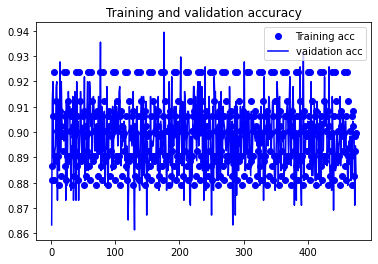

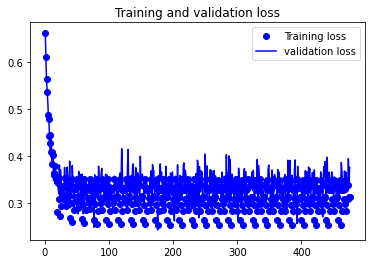

In [629]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accur) + 1)

plt.plot(epochs, train_accur, 'bo', label='Training acc')
plt.plot(epochs, val_accur, 'b', label='vaidation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses_batch, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [630]:
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_alldata = torch.tensor(np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])).to(device)
X_test_alldata = torch.tensor(np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                    np.array([x for x in test_alldata['features_orig']])])).to(device)

train_realdist['features_loan'] = train_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_realdist['features_orig'] = train_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_realdist['features_loan'] = test_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_realdist['features_orig'] = test_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_realdist = torch.tensor(np.hstack([np.array([x for x in train_realdist['features_loan']]),\
                     np.array([x for x in train_realdist['features_orig']])])).to(device)
X_test_realdist = torch.tensor(np.hstack([np.array([x for x in test_realdist['features_loan']]),\
                    np.array([x for x in test_realdist['features_orig']])])).to(device)

train_balanced['features_loan'] = train_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_balanced['features_orig'] = train_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_balanced['features_loan'] = test_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_balanced['features_orig'] = test_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_balanced = torch.tensor(np.hstack([np.array([x for x in train_balanced['features_loan']]),\
                     np.array([x for x in train_balanced['features_orig']])])).to(device)
X_test_balanced = torch.tensor(np.hstack([np.array([x for x in test_balanced['features_loan']]),\
                    np.array([x for x in test_balanced['features_orig']])])).to(device)

In [631]:
X_train_alldata = F.pad(X_train_alldata, pad=(0, closest_perfect_square-X_train_alldata.shape[1]), value=0)
X_test_alldata = F.pad(X_test_alldata, pad=(0, closest_perfect_square-X_test_alldata.shape[1]), value=0)
X_train_realdist = F.pad(X_train_realdist, pad=(0, closest_perfect_square-X_train_realdist.shape[1]), value=0)
X_test_realdist = F.pad(X_test_realdist, pad=(0, closest_perfect_square-X_test_realdist.shape[1]), value=0)
X_train_balanced = F.pad(X_train_balanced, pad=(0, closest_perfect_square-X_train_balanced.shape[1]), value=0)
X_test_balanced = F.pad(X_test_balanced, pad=(0, closest_perfect_square-X_test_balanced.shape[1]), value=0)
X_train_alldata.shape,X_test_alldata.shape,X_train_realdist.shape,X_test_realdist.shape,X_train_balanced.shape,X_test_balanced.shape


(torch.Size([11857, 1089]),
 torch.Size([1320, 1089]),
 torch.Size([4030, 1089]),
 torch.Size([450, 1089]),
 torch.Size([2417, 1089]),
 torch.Size([271, 1089]))

In [632]:
X_train_alldata = torch.tensor(X_train_alldata).view(-1,1,view_shape,view_shape).to(device)
X_test_alldata = torch.tensor(X_test_alldata).view(-1,1,view_shape,view_shape).to(device)
X_train_realdist = torch.tensor(X_train_realdist).view(-1,1,view_shape,view_shape).to(device)
X_test_realdist = torch.tensor(X_test_realdist).view(-1,1,view_shape,view_shape).to(device)
X_train_balanced = torch.tensor(X_train_balanced).view(-1,1,view_shape,view_shape).to(device)
X_test_balanced = torch.tensor(X_test_balanced).view(-1,1,view_shape,view_shape).to(device)
X_train_alldata.shape,X_test_alldata.shape,X_train_realdist.shape,X_test_realdist.shape,X_train_balanced.shape,X_test_balanced.shape


/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/250242968.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_alldata = torch.tensor(X_train_alldata).view(-1,1,view_shape,view_shape).to(device)
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/250242968.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_alldata = torch.tensor(X_test_alldata).view(-1,1,view_shape,view_shape).to(device)
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_8822/250242968.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

(torch.Size([11857, 1, 33, 33]),
 torch.Size([1320, 1, 33, 33]),
 torch.Size([4030, 1, 33, 33]),
 torch.Size([450, 1, 33, 33]),
 torch.Size([2417, 1, 33, 33]),
 torch.Size([271, 1, 33, 33]))

In [633]:
# use the trained CNN model to get logits for the three different splits

CNN_Net.eval()

with torch.no_grad():
    train_logits_cnn_alldata = CNN_Net(X_train_alldata.float())[1]
    test_logits_cnn_alldata = CNN_Net(X_test_alldata.float())[1]
    
    train_logits_cnn_realdist = CNN_Net(X_train_realdist.float())[1]
    test_logits_cnn_realdist = CNN_Net(X_test_realdist.float())[1]
    
    train_logits_cnn_balanced = CNN_Net(X_train_balanced.float())[1]
    test_logits_cnn_balanced = CNN_Net(X_test_balanced.float())[1]

In [634]:
print(CNN_Net(X_train_alldata.float()))

(tensor([[0.1386],
        [0.0661],
        [0.1716],
        ...,
        [0.0688],
        [0.1360],
        [0.1759]], grad_fn=<SigmoidBackward0>), tensor([[-1.8267],
        [-2.6477],
        [-1.5745],
        ...,
        [-2.6059],
        [-1.8493],
        [-1.5444]], grad_fn=<AddmmBackward0>))


In [589]:
train_logits_cnn_alldata,\
test_logits_cnn_alldata,\
train_logits_cnn_realdist,\
test_logits_cnn_realdist,\
train_logits_cnn_balanced,\
test_logits_cnn_balanced

(tensor([[-1.1711],
         [-1.8401],
         [-1.1130],
         ...,
         [-1.6101],
         [-1.5939],
         [-1.0693]]),
 tensor([[-1.5782],
         [-1.5877],
         [-1.3123],
         ...,
         [-1.2958],
         [-1.2878],
         [-1.4761]]),
 tensor([[-1.3411],
         [-1.5229],
         [-1.2912],
         ...,
         [-1.4801],
         [-1.1663],
         [-1.7757]]),
 tensor([[-1.5312],
         [-1.3480],
         [-1.5121],
         [-1.7443],
         [-1.6565],
         [-1.4434],
         [-1.7477],
         [-1.2190],
         [-1.7897],
         [-1.1070],
         [-1.5275],
         [-1.1156],
         [-1.7890],
         [-1.4791],
         [-1.4158],
         [-1.8203],
         [-1.3719],
         [-1.6194],
         [-1.3460],
         [-1.4761],
         [-1.6506],
         [-1.8784],
         [-1.8175],
         [-1.8047],
         [-1.7704],
         [-1.7592],
         [-1.4061],
         [-1.7649],
         [-1.5109],
         [-1